# 1. Постановка задачи

Cпрогнозировать, уйдёт клиент из банка в ближайшее время или нет по предоставленым исторические данные о поведении клиентов и расторжении договоров с банком. 
Построить модель с предельно большим значением F1-меры (не менее 0.59). Проверить F1-меру на тестовой выборке.
Дополнительно измерить AUC-ROC, сравнивая её значение с F1-мерой.

**Описание данных:**


Признаки

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак

- Exited — факт ухода клиента

# 2. Загрузка и подготовка данных

## 2.1 Загрузка данных и импорт библиотек

Импорт библиотек

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import OneHotEncoder

Импорт данных

In [2]:
def read_data_set(pth1, pth2) -> pd.DataFrame:
    df = pd.DataFrame    
    try:
        df = pd.read_csv(pth1)
    except OSError as e:
        df = pd.read_csv(pth2)
    return df

In [3]:
pth1 = 'datasets/Churn.csv'
pth2 = 'https://code.s3.yandex.net/datasets/Churn.csv'

In [4]:
df = read_data_set(pth1, pth2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
df.sample(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7312,7313,15688264,Nkemdilim,629,France,Female,43,0.0,0.00,2,1,1,41263.69,0
7936,7937,15617401,Thomson,468,France,Male,22,2.0,0.00,2,1,0,28123.99,0
5580,5581,15786249,Whitfield,616,Spain,Male,30,2.0,0.00,2,1,0,199099.51,0
5796,5797,15674254,Kerr,554,Spain,Female,45,4.0,0.00,2,1,1,193412.05,0
7831,7832,15635143,Fennescey,749,France,Male,42,2.0,56726.83,2,0,1,185543.35,0
3716,3717,15699492,Lorenzo,665,Germany,Female,27,2.0,147435.96,1,0,0,187508.06,0
1666,1667,15579706,Curtis,611,France,Female,46,5.0,0.00,1,1,0,77677.14,1
6750,6751,15690546,Riley,618,France,Female,42,2.0,0.00,4,0,0,111097.39,1
8125,8126,15666982,Spears,629,Germany,Female,38,9.0,123948.85,1,1,0,76053.07,0
2123,2124,15723320,Azubuike,651,Germany,Female,25,2.0,109175.14,2,1,0,114566.47,0


## 2.2 Подготовка данных

### 2.2.1 Предобработка данных

Приведем наименования столбцов к snake_case

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df.columns = (['row_number', 'customer_id', 'surname', 'credit_score', 'geography', 
               'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_card', 'is_active_member', 'estimated_salary',
              'exited'])

In [10]:
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Столбцы is_active_member, has_card, exited явно булевы а не int

In [11]:
df.is_active_member = df.is_active_member.astype(bool)
df.has_card = df.has_card.astype(bool)

В столбце tenure есть 909 пропусков. Вероятно это программная ошибка. Так как по другим столбцам пропуски заполнить невозможно, придется их отбросить, так как случайный лес и логистическая регрессия не могут работать с NAN

In [12]:
df = df[~df['tenure'].isna() == True]
df = df.reset_index(drop=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        9091 non-null   int64  
 1   customer_id       9091 non-null   int64  
 2   surname           9091 non-null   object 
 3   credit_score      9091 non-null   int64  
 4   geography         9091 non-null   object 
 5   gender            9091 non-null   object 
 6   age               9091 non-null   int64  
 7   tenure            9091 non-null   float64
 8   balance           9091 non-null   float64
 9   num_of_products   9091 non-null   int64  
 10  has_card          9091 non-null   bool   
 11  is_active_member  9091 non-null   bool   
 12  estimated_salary  9091 non-null   float64
 13  exited            9091 non-null   int64  
dtypes: bool(2), float64(3), int64(6), object(3)
memory usage: 870.2+ KB


**Так же было обнаружено следующее:**
1. В столбце surname есть явные ошибки (в частности фамилии с символами "?"). С ними так же что-то сделать невозможно, однако мешать это не будет, так как очевидно, что факт ухода от фамилии не зависит

### 2.2.2 Предобработка признаков

Так как модель учитывает только численные признаки, а признаки geography, gender явно категориальные, создадим для них дамми-признаки c помощью прямого кодирования так как данный метод подходит для всех моделей. Признаки не зависят друг от друга. В дамми ловушку попасть не должны

Так как от фамилии факт ухода точно не зависит, её учитывать не будем

In [14]:
df_ohe = df.drop(['surname', 'row_number', 'customer_id'], axis = 1)
df_ohe.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2.0,0.00,1,True,True,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,False,True,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,True,False,113931.57,1
3,699,France,Female,39,1.0,0.00,2,False,False,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,True,True,79084.10,0


In [15]:
df_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9091 entries, 0 to 9090
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      9091 non-null   int64  
 1   geography         9091 non-null   object 
 2   gender            9091 non-null   object 
 3   age               9091 non-null   int64  
 4   tenure            9091 non-null   float64
 5   balance           9091 non-null   float64
 6   num_of_products   9091 non-null   int64  
 7   has_card          9091 non-null   bool   
 8   is_active_member  9091 non-null   bool   
 9   estimated_salary  9091 non-null   float64
 10  exited            9091 non-null   int64  
dtypes: bool(2), float64(3), int64(4), object(2)
memory usage: 657.1+ KB


Для обучения и проверки моделей необходимо разбить данные на выборки. Поделим датасет на выборки

In [16]:
df_train, df_valid = train_test_split(df_ohe, test_size=0.4, random_state=12345)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345)

In [17]:
df_train.info()
df_valid.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5454 entries, 8483 to 4578
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      5454 non-null   int64  
 1   geography         5454 non-null   object 
 2   gender            5454 non-null   object 
 3   age               5454 non-null   int64  
 4   tenure            5454 non-null   float64
 5   balance           5454 non-null   float64
 6   num_of_products   5454 non-null   int64  
 7   has_card          5454 non-null   bool   
 8   is_active_member  5454 non-null   bool   
 9   estimated_salary  5454 non-null   float64
 10  exited            5454 non-null   int64  
dtypes: bool(2), float64(3), int64(4), object(2)
memory usage: 436.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1818 entries, 6754 to 2218
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0

In [18]:
features_train = df_train.drop('exited', axis= 1)
target_train = df_train.exited
features_valid = df_valid.drop('exited', axis= 1)
target_valid = df_valid.exited
features_test = df_test.drop('exited', axis= 1)
target_test = df_test.exited

In [19]:
encoder = OneHotEncoder(sparse = False, drop = 'first')

In [20]:
encoder.fit(features_train[['geography', 'gender', 'has_card', 'is_active_member']])

C:\Users\usach\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(drop='first', sparse=False, sparse_output=False)

In [21]:
ohe_train = (pd.DataFrame(encoder.transform(features_train[['geography', 'gender', 'has_card', 'is_active_member']]),
                          columns = ['is_spain', 'is_germany', 'female', 'has_card', 'is_acive_member']))
ohe_valid = (pd.DataFrame(encoder.transform(features_valid[['geography', 'gender', 'has_card', 'is_active_member']]),
                          columns = ['is_spain', 'is_germany', 'female', 'has_card', 'is_acive_member']))
ohe_test = (pd.DataFrame(encoder.transform(features_test[['geography', 'gender', 'has_card', 'is_active_member']]),
                          columns = ['is_spain', 'is_germany', 'female', 'has_card', 'is_acive_member']))

In [22]:
features_train = (features_train.drop(['geography', 'gender', 'has_card', 'is_active_member'], axis = 1)
                  .reset_index(drop=True))                  
features_valid = (features_valid.drop(['geography', 'gender', 'has_card', 'is_active_member'], axis = 1)
                 .reset_index(drop=True))                 
features_test = (features_test.drop(['geography', 'gender', 'has_card', 'is_active_member'], axis = 1)
                 .reset_index(drop=True))                 

In [23]:
features_train = features_train.join(ohe_train)
features_valid = features_valid.join(ohe_valid)
features_test = features_test.join(ohe_test)

In [24]:
scaler = StandardScaler()
scaler.fit(features_train) 
features_train = scaler.transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

Так же очевидно, что признаки имеют разный масштаб. Стандартзируем данные

# 3. Исследование баланса классов и обучение модели

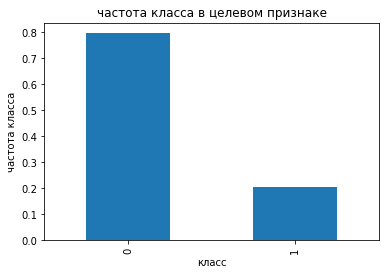

In [25]:
class_frequency = df.exited.value_counts(normalize= True)
class_frequency.plot(kind ='bar');
plt.title('частота класса в целевом признаке');
plt.ylabel('частота класса');
plt.xlabel('класс');
plt.show()

В целевом признаке наблюдается несбалансированность классов (отрицательных ответов явно больше)

Для анализа выберем решающее дерево и посмотрим на балланс классов в его предсказаниях

In [26]:
model = DecisionTreeClassifier(max_depth = 3, random_state= 12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid) 
accuracy_score(target_valid, model.predict(features_valid)) 

0.8333333333333334

In [27]:
f1_score(target_valid, predictions)

0.3726708074534161

In [28]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_score(target_valid, probabilities_one_valid)

0.7994383873562604

Проверим на переобучение

In [29]:
model = DecisionTreeClassifier(max_depth = 5, random_state= 12345)
model.fit(features_train, target_train)
accuracy_score(target_train, model.predict(features_train)) 

0.8553355335533553

модель не переобучена

Посмотрим на балланс классов в предсказаниях

In [30]:
class_frequency = pd.Series(model.predict(features_valid)).value_counts(normalize = True)

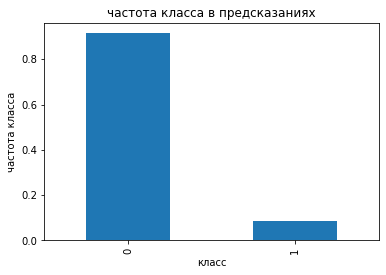

In [31]:
class_frequency
class_frequency.plot(kind ='bar');
plt.title('частота класса в предсказаниях');
plt.ylabel('частота класса');
plt.xlabel('класс');
plt.show()

Аналогично целевому признаку видим дисбаланс

Построим матрицу ошибок

In [32]:
confusion_matrix(target_valid, model.predict(features_valid))

array([[1422,   19],
       [ 240,  137]], dtype=int64)

Аналогично посмотрим остальные модели со случайными гиперпараметрами

In [33]:
model = RandomForestClassifier(n_estimators = 10,max_depth = 5, random_state= 12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid) 
f1_score(target_valid, predictions)

0.511029411764706

In [34]:
model = LogisticRegression(max_iter = 100, random_state= 12345, solver = 'liblinear')
model.fit(features_train, target_train)
predictions = model.predict(features_valid) 
f1_score(target_valid, predictions)

0.3033932135728543

**Вывод:**
В ходе данного этапа был исследован балланс классов и обучено решающее дерево.
По целевому признаку и предсказаниям модели наблюдаем сильный дисбаланс классов (признаки и модель негативны)
На данном этапе для решающего дерева со случайными параметрами была получена f1-мера 0,372, для случайного леса 0,36, для логистической регрессии 0,31 что далеко от требуемого показателя в 0,59

# 4. Улучшение модели

## 4.1. Взвешивание классов

Учтем вес класса при обучении модели

Решающее дерево

In [35]:
def decession_tree(features_train, target_train, features_valid,target_valid, weight):
    best_score = 0
    best_depth = 0   
    for i in range (1,10):         
        model = DecisionTreeClassifier(max_depth = i, random_state= 12345, class_weight= weight)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        score = f1_score(target_valid, predictions)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        if score > best_score:
            best_score = score
            best_depth = i
            roc = roc_auc_score(target_valid, probabilities_one_valid)
    return best_score, best_depth, roc    

In [36]:
best_score, best_depth, roc = decession_tree(features_train, target_train, features_valid,target_valid,'balanced')

In [37]:
print('f1-мера:',best_score)
print('глубина:',best_depth)
print('roc:',roc)

f1-мера: 0.5735449735449736
глубина: 5
roc: 0.8396523192522141


Случайный лес

In [38]:
def random_forest(features_train, target_train, features_valid,target_valid, weight):
    best_score = 0
    best_depth = 0   
    for i in range (1,10):         
        model = RandomForestClassifier(n_estimators = 150, max_depth = i, random_state= 12345, class_weight= weight)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        score = f1_score(target_valid, predictions)
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        if score > best_score:
            best_score = score
            best_depth = i
            roc = roc_auc_score(target_valid, probabilities_one_valid)
    return best_score, best_depth, roc  

In [39]:
best_score, best_depth, roc = random_forest(features_train, target_train, features_valid,target_valid,'balanced')

In [40]:
print('f1-мера:',best_score)
print('глубина:',best_depth)
print('roc:',roc)

f1-мера: 0.6464646464646465
глубина: 9
roc: 0.8700578179388393


In [41]:
def logistic_regression(features_train, target_train, features_valid,target_valid, weight):
    best_score = 0
    best_depth = 0   
    for i in range (100,1000,100):         
        model = LogisticRegression(max_iter = i, random_state= 12345, solver = 'liblinear', class_weight= weight)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        score = f1_score(target_valid, predictions)   
        probabilities_valid = model.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        if score > best_score:
            best_score = score
            best_depth = i
            roc = roc_auc_score(target_valid, probabilities_one_valid)
    return best_score, best_depth, roc  

In [42]:
best_score, best_depth, roc = (logistic_regression(features_train,
                                                   target_train, features_valid,target_valid,'balanced'))

In [43]:
print('f1-мера:',best_score)
print('количество итераций:',best_depth)
print('roc:',roc)

f1-мера: 0.509731232622799
количество итераций: 100
roc: 0.7777515982306715


## 4.2. Увеличение выборки

В данном пункте используем технику upsampling

In [44]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [45]:
features_train_up = df_train.drop('exited', axis= 1)
target_train_up = df_train.exited

In [46]:
features_train

array([[ 0.8090755 , -1.03932669, -1.02599468, ..., -1.10730414,
         0.66346825, -1.02412668],
       [-1.15251812, -1.22756099,  0.69652425, ...,  0.90309425,
        -1.50723112, -1.02412668],
       [-0.3988532 ,  0.09007912,  1.38553182, ...,  0.90309425,
         0.66346825,  0.9764417 ],
       ...,
       [-1.04927635, -0.94520954,  0.35202046, ..., -1.10730414,
         0.66346825,  0.9764417 ],
       [-0.95635876,  1.21948493,  1.38553182, ..., -1.10730414,
         0.66346825, -1.02412668],
       [ 1.22204257, -1.50991244, -1.02599468, ...,  0.90309425,
        -1.50723112,  0.9764417 ]])

In [47]:
features_upsampled, target_upsampled = upsample(features_train_up,target_train_up, 4)

In [48]:
ohe_train = (pd.DataFrame(encoder.transform(features_upsampled[['geography', 'gender', 'has_card', 'is_active_member']]),
                          columns = ['is_spain', 'is_germany', 'female', 'has_card', 'is_acive_member']))
features_upsampled = (features_upsampled.drop(['geography', 'gender', 'has_card', 'is_active_member'], axis = 1)
                  .reset_index(drop=True))  
features_upsampled = features_upsampled.join(ohe_train)

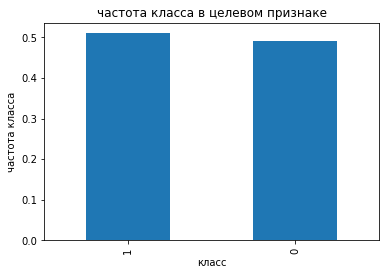

In [49]:
class_frequency = target_upsampled.value_counts(normalize= True)
class_frequency.plot(kind ='bar');
plt.title('частота класса в целевом признаке');
plt.ylabel('частота класса');
plt.xlabel('класс');
plt.show()

Проверим на моделях

In [50]:
best_score, best_depth, roc = decession_tree(features_upsampled, target_upsampled, features_valid,target_valid, None)

C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:4

In [51]:
print('f1-мера:',best_score)
print('глубина:',best_depth)
print('roc:',roc)

f1-мера: 0.4457013574660634
глубина: 4
roc: 0.6687028423011576


In [52]:
best_score, best_depth, roc = random_forest(features_upsampled, target_upsampled, features_valid,target_valid, None)

C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:4

In [53]:
print('f1-мера:',best_score)
print('глубина:',best_depth)
print('roc:',roc)

f1-мера: 0.42879019908116384
глубина: 1
roc: 0.7145945657396039


In [54]:
best_score, best_depth, roc = logistic_regression(features_upsampled, target_upsampled, features_valid,target_valid, None)

C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X d

In [55]:
print('f1-мера:',best_score)
print('глубина:',best_depth)
print('roc:',roc)

f1-мера: 0.4625850340136054
глубина: 100
roc: 0.7466539777674288


## 4.3. Уменьшение выборки

В данном пункте используем технику downsampling

In [56]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled 

In [57]:
features_train_do = df_train.drop('exited', axis= 1)
target_train_do = df_train.exited

In [58]:
features_downsampled, target_downsampled = downsample(features_train_do, target_train_do, 0.25)

In [59]:
ohe_train = (pd.DataFrame(encoder.transform(features_downsampled[['geography', 'gender', 'has_card', 'is_active_member']]),
                          columns = ['is_spain', 'is_germany', 'female', 'has_card', 'is_acive_member']))
features_downsampled = (features_downsampled.drop(['geography', 'gender', 'has_card', 'is_active_member'], axis = 1)
                  .reset_index(drop=True))  
features_downsampled = features_downsampled.join(ohe_train)

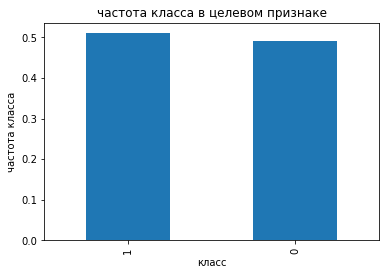

In [60]:
class_frequency = target_downsampled.value_counts(normalize= True)
class_frequency.plot(kind ='bar');
plt.title('частота класса в целевом признаке');
plt.ylabel('частота класса');
plt.xlabel('класс');
plt.show()

Проверим на моделях

In [61]:
best_score, best_depth, roc = decession_tree(features_downsampled, target_downsampled, features_valid,target_valid, None)

C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:4

In [62]:
print('f1-мера:',best_score)
print('глубина:',best_depth)
print('roc:',roc)

f1-мера: 0.4457013574660634
глубина: 4
roc: 0.6387151937296712


In [63]:
best_score, best_depth, roc = random_forest(features_downsampled, target_downsampled, features_valid,target_valid, None)

C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:4

In [64]:
print('f1-мера:',best_score)
print('глубина:',best_depth)
print('roc:',roc)

f1-мера: 0.45739910313901344
глубина: 2
roc: 0.7227711746006034


In [65]:
best_score, best_depth, roc = logistic_regression(features_downsampled, target_downsampled, features_valid,target_valid, None)

C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\usach\anaconda3\lib\site-packages\sklearn\base.py:464: UserWarning: X d

In [66]:
print('f1-мера:',best_score)
print('глубина:',best_depth)
print('roc:',roc)

f1-мера: 0.45578231292517
глубина: 100
roc: 0.7408335281459789


## 4.4. Снижение порога классификации логистической регрессии

In [68]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

In [69]:
for threshold in np.arange(0, 0.4, 0.02):
    predicted_valid = probabilities_one_valid > threshold    
    score = f1_score(target_valid, predicted_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    roc = roc_auc_score(target_valid, probabilities_one_valid )
    print("Порог = {:.2f} | f1-мера = {:.3f}, auc-roc = {:.3f}".format(
        threshold, score, roc))

Порог = 0.00 | f1-мера = 0.344, auc-roc = 0.774
Порог = 0.02 | f1-мера = 0.344, auc-roc = 0.774
Порог = 0.04 | f1-мера = 0.356, auc-roc = 0.774
Порог = 0.06 | f1-мера = 0.376, auc-roc = 0.774
Порог = 0.08 | f1-мера = 0.400, auc-roc = 0.774
Порог = 0.10 | f1-мера = 0.417, auc-roc = 0.774
Порог = 0.12 | f1-мера = 0.443, auc-roc = 0.774
Порог = 0.14 | f1-мера = 0.459, auc-roc = 0.774
Порог = 0.16 | f1-мера = 0.477, auc-roc = 0.774
Порог = 0.18 | f1-мера = 0.488, auc-roc = 0.774
Порог = 0.20 | f1-мера = 0.498, auc-roc = 0.774
Порог = 0.22 | f1-мера = 0.507, auc-roc = 0.774
Порог = 0.24 | f1-мера = 0.504, auc-roc = 0.774
Порог = 0.26 | f1-мера = 0.501, auc-roc = 0.774
Порог = 0.28 | f1-мера = 0.499, auc-roc = 0.774
Порог = 0.30 | f1-мера = 0.489, auc-roc = 0.774
Порог = 0.32 | f1-мера = 0.471, auc-roc = 0.774
Порог = 0.34 | f1-мера = 0.459, auc-roc = 0.774
Порог = 0.36 | f1-мера = 0.450, auc-roc = 0.774
Порог = 0.38 | f1-мера = 0.430, auc-roc = 0.774


**Вывод:**

В ходе данного этапа были улучшены модели из этапа 3. Для увеличения f1-меры был использован перебор гиперпараметров моделей а так же техники "балансирования" классов

Наибольшую эффективность показало "взвешивание" классов, при котором f1-мера была увеличена и:

- для решающего дерева составила 0.52 на валидационной выборке 
- для случайного леса составила 0,64 на валидационной выборке
- для логистической регрессии составила 0,51 на валидационной выборке

# 5. Финальное тестирование

Наилучий результат показал случайный лес c балансированными классами. Протестируем на тестовой выборке

In [70]:
model = RandomForestClassifier(n_estimators = 150, max_depth = 8, random_state= 12345, class_weight= 'balanced')
model.fit(features_train, target_train)
predictions = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

In [71]:
print('f1-мера:',f1_score(target_test, predictions))
print('roc:',roc_auc_score(target_test, probabilities_one_test))

f1-мера: 0.6027742749054225
roc: 0.8586696631655759


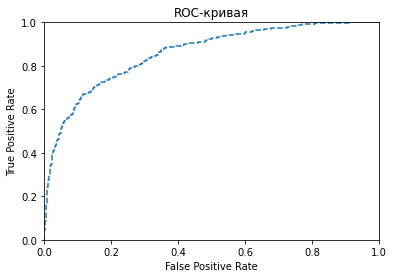

In [72]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) 
plt.figure()
plt.plot(fpr,tpr, linestyle='--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Значение f1-меры > 0.59. Условие задачи выполнено

# 6. Общий вывод

**Цель работы: **

Cпрогнозировать, уйдёт клиент из банка в ближайшее время или нет по предоставленым исторические данные о поведении клиентов и расторжении договоров с банком. 
Построить модель с предельно большим значением F1-меры (не менее 0.59). Проверить F1-меру на тестовой выборке.
Дополнительно измерить AUC-ROC, сравнивая её значение с F1-мерой.

Для выполнения данной задачи были проведены следующие этапы:

 - Загрузка и подготовка данных
 - Исследование баланса классов и обучение модели
 - Улучшение модели
 - Финальное тестирование

В ходе загрузки и подготовки данных были загружены необходимые библиотеки, датасет, была произведена предобработка данных, а именно:

    - столбцы приведены snake_case
    - отброшены пропущенные значения (NAN)
    - исправлены ошибки в типах

Так же было выполнено прямое кодирование категориальных признаков и подготовлены тренировочная, валидационная и тестовая выборки   

В ходе исследования баланса классов и обучения модели был исследован балланс классов и обучено решающее дерево.
По целевому признаку и предсказаниям модели наблюдаем сильный дисбаланс классов (признаки и модель негативны)
На данном этапе для решающего дерева со случайными параметрами была получена f1-мера 0,372, для случайного леса 0,36, для логистической регрессии 0,31 что далеко от требуемого показателя в 0,59. Частоты классов в целевом признаке и предсказаниях модели даны на графиках ниже

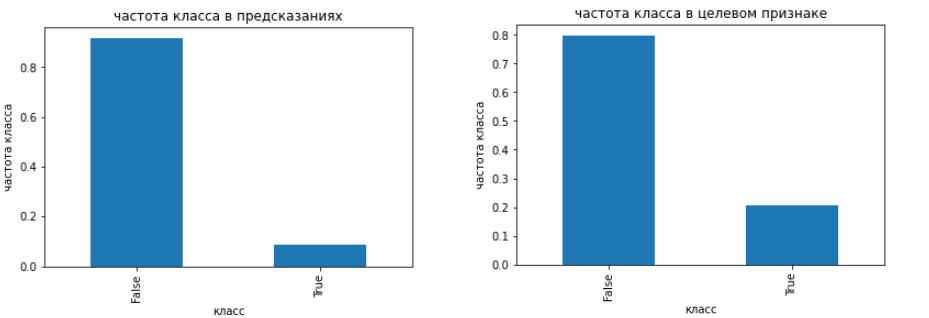

В ходе улучшения модели были улучшены модели из предыдущего этапа. Для увеличения f1-меры был использован перебор гиперпараметров моделей а так же техники "балансирования" классов

Наибольшую эффективность показало "взвешивание" классов, при котором f1-мера была увеличена и:

- для решающего дерева составила 0.52 на валидационной выборке 
- для случайного леса составила 0,64 на валидационной выборке
- для логистической регрессии составила 0,51 на валидационной выборке

В ходе финального тестирования было проведено тестирования модели, c наибольшим значением f-1 выборки и лучшими гиперпараметрами из предыдущего этапа - случайного леса

На тестовой выборке удалось достичь f1-меры: 0.61, что больше заданной (0.59)

Для проверки была построена ROC-кривая

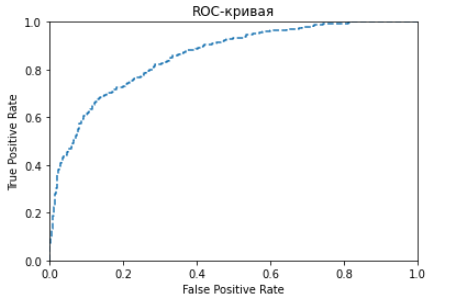